# Test Backtrader Module

In [11]:
import os
print(os.getcwd())
import pandas as pd
with open('taiwan_stock_index_10y.csv','r',encoding='utf-8') as file:
    stock_tw_df = pd.read_csv(file)
# stock_tw_df.columns
stock_tw_df = stock_tw_df.set_index("Date")
stock_tw_df.index = pd.to_datetime(stock_tw_df.index)
stock_tw_df.dtypes
stock_tw_df

/opt/ccclub/sola/backtest


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2014-06-05,9127.559570,9140.719727,9094.129883,9140.719727,9140.685547,2772700
2014-06-06,9167.830078,9174.769531,9122.559570,9134.459961,9134.425781,2858700
2014-06-09,9153.929688,9166.580078,9138.929688,9162.740234,9162.706055,2464400
2014-06-10,9181.900391,9222.370117,9171.750000,9222.370117,9222.335938,2518700
2014-06-11,9218.500000,9229.799805,9204.759766,9229.799805,9229.765625,2437300
...,...,...,...,...,...,...
2024-05-27,21699.980470,21871.339840,21699.980470,21803.769530,21803.769530,4877400
2024-05-28,21812.199220,21937.400390,21812.199220,21858.410160,21858.410160,4906000
2024-05-29,21846.410160,21906.099610,21662.500000,21662.500000,21662.500000,5223800


In [1]:
from __future__ import (absolute_import, division, print_function, unicode_literals)
import backtrader as bt
import yfinance as yf
from FinMind.data import DataLoader

In [13]:
api = DataLoader()
df = api.taiwan_stock_daily(
    stock_id='2330',
    start_date = '2022-01-01',
    end_date= '2024-01-01'
)
df

2024-06-14 14:17:17.797 | INFO     | FinMind.data.finmind_api:get_data:125 - download TaiwanStockPrice, data_id: 2330


,date,stock_id,Trading_Volume,Trading_money,open,max,min,close,spread,Trading_turnover
0,2022-01-03,2330,73703302,46249716919,619.0,632.0,618.0,631.0,16.0,88508
1,2022-01-04,2330,90945643,59188199534,645.0,656.0,644.0,656.0,25.0,106409
2,2022-01-05,2330,72505550,47582832784,669.0,669.0,646.0,650.0,-6.0,64712
3,2022-01-06,2330,57490736,36817638522,638.0,646.0,636.0,644.0,-6.0,53430
4,2022-01-07,2330,39847766,25358237656,643.0,646.0,632.0,634.0,-10.0,44497
...,...,...,...,...,...,...,...,...,...,...
480,2023-12-25,2330,9994163,5820235840,582.0,585.0,580.0,581.0,-1.0,12786
481,2023-12-26,2330,17033926,9963615754,583.0,586.0,582.0,586.0,5.0,22883
482,2023-12-27,2330,34750958,20491144772,587.0,592.0,586.0,592.0,6.0,37372
483,2023-12-28,2330,27152352,16064106365,592.0,593.0,589.0,593.0,1.0,26497


In [2]:
class TestStrategy(bt.Strategy):
    # params = (
    #     ('maperiod', 20),  # 默認參數值
    #     ('exitbars', 5),
    # )
    params = (
        ('fast_length', 10),
        ('slow_length', 50)
    )

    def log(self, txt, df=None):
        '''records'''
        df = df or self.datas[0].datetime.date(0)
        print('%s, %s' % (df.isoformat(), txt))
    def __init__(self):
        # Keep a reference to the "close" line in the data[0] dataseries
        self.dataclose = self.datas[0].close
        # To keep track of pending orders
        self.order = None
        self.buyprice = None
        self.buycomm = None

        # self.sma = bt.indicators.MovingAverageSimple(self.datas[0], period=self.params.maperiod)
        ma_fast = bt.ind.SMA(period = self.params.fast_length)
        ma_slow = bt.ind.SMA(period = self.params.slow_length)
        self.crossover = bt.ind.CrossOver(ma_fast, ma_slow)
        
        # 增加畫線的指標
        bt.indicators.ExponentialMovingAverage(self.datas[0], period=25)
        bt.indicators.WeightedMovingAverage(self.datas[0], period=25, subplot=True)
        bt.indicators.StochasticSlow(self.datas[0])
        bt.indicators.MACDHisto(self.datas[0])
        rsi = bt.indicators.RSI(self.datas[0])
        bt.indicators.SmoothedMovingAverage(rsi, period=10)
        bt.indicators.ATR(self.datas[0],plot=False)
    
    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            return
        if order.status in [order.Completed]:
            if order.isbuy():
                # self.log('BUY EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        #   (order.executed.price, order.executed.value, order.executed.comm))
                self.buyprice = order.executed.price
                self.buycomm = order.executed.comm
            elif order.issell():
                pass
                # self.log('SELL EXECUTED, Price: %.2f, Cost: %.2f, Comm %.2f' %
                        #   (order.executed.price, order.executed.value, order.executed.comm))
            self.bar_executed = len(self)
            
        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            pass
            # self.log('Order Canceled/Margin/Rejected')
        
        self.order = None

    def notify_trade(self, trade): # 交易執行後, 處理相關資訊
        if not trade.isclosed:
            return
        # self.log("OPERATION PROFIT, GROSS %.2f, NET %.2f" % 
                #  (trade.pnl, trade.pnlcomm)) # 紀錄盈利數據

    def next(self):
        # self.log("Close, %.2f" % self.dataclose[0])
        # check if an order is pending... if yes, we cannot send a 2nd one
        if self.order:
            return
        # 檢查是否在市場
        if not self.position:
            if not self.crossover > 0:
                self.buy()
            # if self.dataclose[0] > self.sma[0]:
            #     # self.log("BUY CREATE, %.2f" %  self.dataclose[0])
            #     self.order = self.buy()
            # if self.dataclose[0] < self.dataclose[-1]:
            #     if self.dataclose[-1] < self.dataclose[-2]:
            #         self.log('BUY CREATE, %.2f' % self.dataclose[0])
            #         self.order = self.buy()
        else:
            if self.crossover < 0:
                self.close()
            # if self.dataclose[0] < self.sma[0]:
            #     # self.log("SELL CREATE %.2f" % self.dataclose[0])
            #     self.order = self.sell()

            # 在市場中, 五天後賣
            # len(self)是當前執行bar數量, 每次next會增加1, 而self.bar_executed會紀錄最後一次交易執行時bar位置
            # if len(self) >= (self.bar_executed + self.params.exitbars):
            #     self.log('SELL CREATE, %.2f' % self.dataclose[0])
            #     # keep track of the created order to avoid a 2nd order
            #     self.order = self.sell()


[*********************100%%**********************]  1 of 1 completed


夏普比率: -0.3441581965485948
最大回撤%: 3.37%
年化收益率%: 0.53%


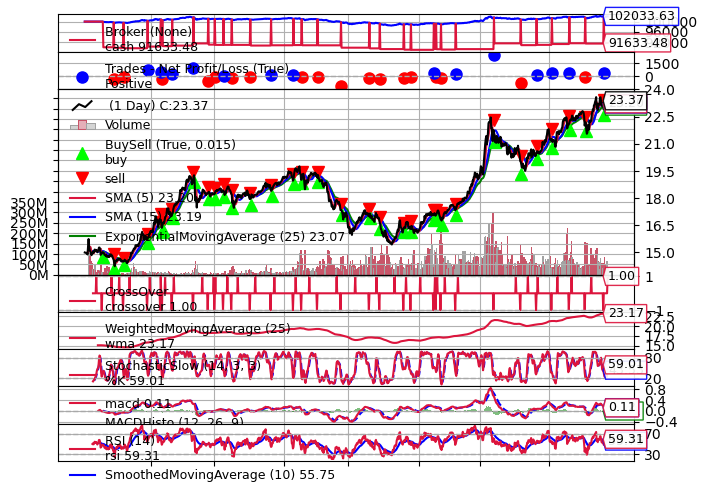

[[<Figure size 640x480 with 9 Axes>]]

In [5]:
import backtrader as bt

from datetime import datetime 
import matplotlib.pyplot as plt
%matplotlib inline

cerebro = bt.Cerebro()

# cerebro.addstrategy(TestStrategy, maperiod=19, exitbars=15)
cerebro.addstrategy(TestStrategy, fast_length=5, slow_length=15)

# 增加多參數策略
# strats = cerebro.optstrategy(
#     TestStrategy,
#     fast_length = range(5,19),
#     slow_length = range(20,60)
# )


# start_date = datetime(2014,1,1)
# end_date = datetime(2024,5,31)

# data = bt.feeds.PandasData(dataname=stock_tw_df, fromdate=start_date, todate=end_date)
# cerebro.adddata(data)

# 添加數據
data = bt.feeds.PandasData(dataname=yf.download("00878.TW", 
                                                start="2020-01-01", 
                                                end="2024-11-22"))
cerebro.adddata(data)

# cerebro.addsizer(bt.sizers.FixedSize, stake=3)
cerebro.addsizer(bt.sizers.PercentSizer, percents = 10)
# 添加分析器
cerebro.addanalyzer(bt.analyzers.SharpeRatio, _name = "sharpe")
cerebro.addanalyzer(bt.analyzers.DrawDown, _name = "drawdown")
cerebro.addanalyzer(bt.analyzers.Returns, _name = "returns")

cerebro.broker.setcash(100000)
cerebro.broker.setcommission(commission=0.004)

# print("Starting Portfolio Value: %.2f" %cerebro.broker.getvalue())
results = cerebro.run()
# print("Final Portfolio Value: %.2f" %cerebro.broker.getvalue())

# # 獲取分析結果
sharpe_ratio = results[0].analyzers.sharpe.get_analysis()
drawdown = results[0].analyzers.drawdown.get_analysis()
returns = results[0].analyzers.returns.get_analysis()

print(f"夏普比率: {sharpe_ratio['sharperatio']}")
print(f"最大回撤%: {round(drawdown['max']['drawdown'],2)}%")
print(f"年化收益率%: {round(returns['rnorm100'],2)}%")

# # 繪製結果
cerebro.plot(iplot=False)

In [17]:
par_list = [[ x[0].params.fast_length,
             x[0].params.slow_length,
             x[0].analyzers.returns.get_analysis()['rnorm100'],
             x[0].analyzers.drawdown.get_analysis()['max']['drawdown'],
             x[0].analyzers.sharpe.get_analysis()['sharperatio']
] for x in results]

In [18]:
par_df =  pd.DataFrame(par_list, columns= ['length_fast', 'length_slow', 'return','drawdown','sharp'])
print("finish opt strategy:", datetime.now())
par_df = par_df.sort_values(by=['return'], ascending=False)
par_df.to_csv('result.csv')

finish opt strategy: 2024-06-14 09:43:45.927009


In [19]:
par_df

,length_fast,length_slow,return,drawdown,sharp
116,7,56,1.385976,4.237844,0.091042
76,6,56,1.385976,4.237844,0.091042
119,7,59,1.265187,4.387108,0.058588
79,6,59,1.226908,4.387108,0.050354
62,6,42,1.225114,4.811386,0.046947
...,...,...,...,...,...
410,15,30,-1.044110,6.495464,-0.382735
2,5,22,-1.086682,6.879848,-0.383809
480,17,20,-1.179608,6.731612,-0.422206
520,18,20,-1.388075,7.057313,-0.444316


# Test Signal Backtrader for eps filter

# All Stock Backtest